In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
datapath = '/content/drive/MyDrive/niloy-2-level - Sheet1 (1).csv'
df = pd.read_csv(datapath)
df = df.dropna(subset=['Category'])
df.head()

,Text,Category
0,একটা বেকার ছেলের মাকে খুন করার মত মানসিকতা তৈর...,ranoAG
1,আরিফ ভাই রোহিঙ্গাদেদেরও সাহায্য করুন।,ranoAG
2,বাংলাদেশে নির্বাচন আসলে ব্যাপক বিনোদন ফ্রিতে প...,ranoAG
3,বিশ্বকাপ চলাকালীন সময়ে আমরা দিরিলিস আর্তগোল দ...,ranoAG
4,চাকুরীর আশা বাদ দিয়ে যদি কিছু করা যায় তবে মন্দ...,ranoAG


<Axes: xlabel='Category'>

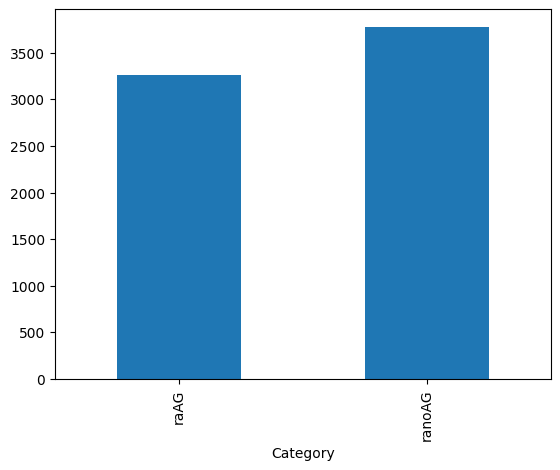

In [ ]:
df.groupby(['Category']).size().plot.bar()

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")
#from transformers import AutoTokenizer
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
example_text = 'আমি তাকে মেরে ফেলবো'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10,
                       truncation=True, return_tensors="pt")

print(tokenizer)
#print(bert_input['input_ids'])
#print(bert_input['token_type_ids'])
#print(bert_input['attention_mask'])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


BertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [ ]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] আমি তাকে ম [SEP]


In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer
#from transformers import AutoTokenizer
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")
labels = {'raAG':0,
          'ranoAG':1,

          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

5630 704 704


In [ ]:
from torch import nn
from transformers import BertModel
#from transformers import AutoTokenizer
#from transformers import AutoModelForSequenceClassification




class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()
        #self.bert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
        self.bert = BertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:

from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train(model, train_data, val_data, test_data,learning_rate, epochs):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            model.eval()
            test_labels = []
            test_preds = []
            with torch.no_grad():
                for test_input, test_label in test_dataloader:
                    test_labels += test_label.tolist()
                    test_label = test_label.to(device)
                    mask = test_input['attention_mask'].to(device)
                    input_id = test_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)
                    preds = output.argmax(dim=1).tolist()
                    test_preds += preds
            precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
            print(f'Test Precision: {precision:.4f} | Test Recall: {recall:.4f} | Test F1 Score: {f1_score:.4f}')


EPOCHS = 7
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val,df_test ,LR, EPOCHS)



"""
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train(model, train_data, val_data, test_data, learning_rate, epochs):

    # create dataloaders for training, validation, and test sets
    train, val ,test= Dataset(train_data), Dataset(val_data),Dataset(test_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)



    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # create optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    for epoch_num in range(epochs):

        # training loop
         for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

        # test loop
        model.eval()
        test_labels = []
        test_preds = []
        with torch.no_grad():
            for test_input, test_label in test_dataloader:
                test_labels += test_label.tolist()
                test_label = test_label.to(device)
                mask = test_input['attention_mask'].to(device)
                input_id = test_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                preds = output.argmax(dim=1).tolist()
                test_preds += preds
        precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
        print(f'Test Precision: {precision:.4f} | Test Recall: {recall:.4f} | Test F1 Score: {f1_score:.4f}')

        # update model parameters

"""


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.2.ffn.lin2.bias', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'vocab_layer_norm.bias', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.2.attention.v_lin.bias', 'distilbert.transformer.layer.1.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.out_lin.weight', 'distilbert.transformer.layer.3.output_layer_norm.bias', 'distilbert.transformer.layer.3.attention.q_lin.weight', 'distilbert.transformer.layer.3.output_layer_norm.weight', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.3.attention.q_lin.bias', 'distilbert.transformer.layer.4.attention.out_lin.bias', 'distilbert.transformer.layer.

Epochs: 1 | Train Loss:  0.342                 | Train Accuracy:  0.640                 | Val Loss:  0.292                 | Val Accuracy:  0.719
Test Precision: 0.7294 | Test Recall: 0.7045 | Test F1 Score: 0.6906


100%|██████████| 2815/2815 [10:01<00:00,  4.68it/s]


Epochs: 2 | Train Loss:  0.249                 | Train Accuracy:  0.767                 | Val Loss:  0.227                 | Val Accuracy:  0.811
Test Precision: 0.8086 | Test Recall: 0.8082 | Test F1 Score: 0.8083


100%|██████████| 2815/2815 [10:02<00:00,  4.67it/s]


Epochs: 3 | Train Loss:  0.212                 | Train Accuracy:  0.818                 | Val Loss:  0.205                 | Val Accuracy:  0.835
Test Precision: 0.8211 | Test Recall: 0.8210 | Test F1 Score: 0.8211


100%|██████████| 2815/2815 [10:02<00:00,  4.67it/s]


Epochs: 4 | Train Loss:  0.191                 | Train Accuracy:  0.842                 | Val Loss:  0.201                 | Val Accuracy:  0.842
Test Precision: 0.8424 | Test Recall: 0.8423 | Test F1 Score: 0.8421


100%|██████████| 2815/2815 [10:02<00:00,  4.67it/s]


Epochs: 5 | Train Loss:  0.175                 | Train Accuracy:  0.854                 | Val Loss:  0.210                 | Val Accuracy:  0.838
Test Precision: 0.8495 | Test Recall: 0.8438 | Test F1 Score: 0.8422


100%|██████████| 2815/2815 [10:02<00:00,  4.68it/s]


Epochs: 6 | Train Loss:  0.163                 | Train Accuracy:  0.871                 | Val Loss:  0.179                 | Val Accuracy:  0.851
Test Precision: 0.8632 | Test Recall: 0.8622 | Test F1 Score: 0.8618


100%|██████████| 2815/2815 [10:02<00:00,  4.67it/s]


Epochs: 7 | Train Loss:  0.156                 | Train Accuracy:  0.875                 | Val Loss:  0.185                 | Val Accuracy:  0.864
Test Precision: 0.8710 | Test Recall: 0.8693 | Test F1 Score: 0.8688


'\nfrom torch.optim import Adam\nfrom tqdm import tqdm\nfrom sklearn.metrics import precision_recall_fscore_support\n\ndef train(model, train_data, val_data, test_data, learning_rate, epochs):\n\n    # create dataloaders for training, validation, and test sets\n    train, val ,test= Dataset(train_data), Dataset(val_data),Dataset(test_data)\n    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)\n    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)\n    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)\n\n\n\n    use_cuda = torch.cuda.is_available()\n    device = torch.device("cuda" if use_cuda else "cpu")\n\n    # create optimizer and loss function\n    criterion = nn.CrossEntropyLoss()\n    optimizer = Adam(model.parameters(), lr=learning_rate)\n\n    for epoch_num in range(epochs):\n\n        # training loop\n         for epoch_num in range(epochs):\n\n            total_acc_train = 0\n            total_loss_train = 0\n\n  

In [ ]:
labels = {'raAG': 0, 'ranoAG': 1}
inv_labels = {v: k for k, v in labels.items()}

# evaluate on test set and get individual metrics for each class
test = Dataset(df_test)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
test_labels = []
test_preds = []
with torch.no_grad():
    for test_input, test_label in test_dataloader:
        test_labels += test_label.tolist()
        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        preds = output.argmax(dim=1).tolist()
        test_preds += preds

precision, recall, f1_score, support = precision_recall_fscore_support(test_labels, test_preds, labels=list(labels.values()), average=None)

# print individual metrics for each class
for i, label in inv_labels.items():
    print(f"Metrics for {label}:")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1_score[i]:.4f}")
    print(f"Support: {support[i]}")
#This code first defines the mapping between the class labels and their corresponding indices, and then uses precision_recall_fscore_support with labels=list(labels.values()) and average=None to get the individual metrics for each class. Finally, it prints the metrics for each class using the inv_labels dictionary to map the indices back to their original labels.








Metrics for raAG:
Precision: 0.8940
Recall: 0.8182
F1-score: 0.8544
Support: 330
Metrics for ranoAG:
Precision: 0.8507
Recall: 0.9144
F1-score: 0.8814
Support: 374


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

evaluate(model, df_test)

#Confusion Matrix
